In [1]:
# --- Setup and Installation ---
# Install rasterio for geospatial raster data processing (if not already installed)
!pip install -q rasterio

# --- Standard Library Imports ---
import os
import gc  # Garbage collection for memory management
import itertools
from pathlib import Path

# --- Data Manipulation and Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Geospatial Data Processing ---
import rasterio
from rasterio.windows import Window # For efficient reading of large satellite images

# --- Machine Learning and Statistics ---
from scipy.stats import skew, kurtosis # Statistical features
import optuna # Hyperparameter optimization framework

# Scikit-learn utilities
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold


# Gradient Boosting Model
from catboost import Pool, CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 39.8 MB/s eta 0:00:00:00:0100:01


/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [2]:
# --- Configuration & File Paths ---

# Constant for numerical stability (avoids division by zero)
EPSILON = 1e-8

# Define a standard tile size for padding (ensures all inputs have consistent dimensions)
TILE_SIZE = 326

# Define the base directory for the input data.
# NOTE: These paths are configured for the Kaggle environment.
# If running locally, change BASE_DIR to your local data location.
BASE_DIR = Path("/kaggle/input/zindi-bytesize")

# Path to the satellite images directory
# The structure assumes a parent S2Images folder containing 'train' and 'test' subfolders
DATA_PATH = BASE_DIR / "S2Images" / "S2Images"
TRAIN_IMAGES_PATH = DATA_PATH / "train"
TEST_IMAGES_PATH = DATA_PATH / "test"

# Paths to the CSV files containing labels and metadata
TRAIN_CSV_PATH = BASE_DIR / "TrainDataset.csv"
TEST_CSV_PATH = BASE_DIR / "TestDataset.csv"

# Output path for the submission file
SUBMISSION_PATH = "submission.csv"

# Quick verification to ensure data is accessible
if TRAIN_IMAGES_PATH.exists() and Path(TRAIN_CSV_PATH).exists():
    print(f"Data directories found.\n   Images: {TRAIN_IMAGES_PATH}\n   Train CSV: {TRAIN_CSV_PATH}")
else:
    print("Warning: Data directories not found. Please check BASE_DIR.")

Data directories found.
   Images: /kaggle/input/zindi-bytesize/S2Images/S2Images/train
   Train CSV: /kaggle/input/zindi-bytesize/TrainDataset.csv


In [3]:
# --- Utility Functions ---

def count_all_files(folder_path: Path) -> int:
    """
    Recursively counts the number of files in a directory and its subdirectories.
    
    Args:
        folder_path (Path or str): The path to the directory to search.
        
    Returns:
        int: The total count of files found.
    """
    file_count = 0
    # os.walk is efficient for traversing directory trees
    for root, dirs, files in os.walk(folder_path):
        file_count += len(files)
    return file_count

# --- Data Verification ---

# Check Training Data Volume
train_count = count_all_files(TRAIN_IMAGES_PATH)
print(f"Total training images in '{TRAIN_IMAGES_PATH}': {train_count}")
# Expected: ~7433

# Check Test Data Volume
test_count = count_all_files(TEST_IMAGES_PATH)
print(f"Total test images in '{TEST_IMAGES_PATH}': {test_count}")
# Expected: ~2201

Total training images in '/kaggle/input/zindi-bytesize/S2Images/S2Images/train': 7433
Total test images in '/kaggle/input/zindi-bytesize/S2Images/S2Images/test': 2201


In [4]:
# --- Load Metadata ---
train = pd.read_csv(TRAIN_CSV_PATH)
test = pd.read_csv(TEST_CSV_PATH)

In [5]:
def update_file_path(current_path, new_base_dir):
    """
    Updates the file path in the dataframe to match the current environment's directory structure.
    
    It extracts the filename from the original path (handling potential backslashes 
    from Windows paths) and appends it to the new base directory.
    
    Args:
        current_path (str): The original path string from the CSV.
        new_base_dir (Path): The new parent directory (TRAIN_IMAGES_PATH or TEST_IMAGES_PATH).
        
    Returns:
        str: The corrected, absolute path to the file.
    """
    # specific handling to ensure forward slashes are used (Linux/Kaggle standard)
    base = str(new_base_dir).replace("\\", "/")
    
    # Extract filename: split by '/' or '\' to be robust against different OS path separators
    filename = str(current_path).replace("\\", "/").split('/')[-1]
    
    return f"{base}/{filename}"

# Apply path corrections
print("🔄 Updating file paths in DataFrames...")
train['tifPath'] = train['tifPath'].apply(update_file_path, args=(TRAIN_IMAGES_PATH,))
test['tifPath'] = test['tifPath'].apply(update_file_path, args=(TEST_IMAGES_PATH,))

# Display the first few rows to verify the paths and see available columns (Crop_ID_1, etc.)
print("✅ Training Data Preview:")
display(train.head(5))

🔄 Updating file paths in DataFrames...
✅ Training Data Preview:


,ID,year,month,tifPath,Target,class
0,ID_h14T0B_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...,Rubber,3
1,ID_KbyKOr_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...,Rubber,3
2,ID_t4Tmmn_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...,Rubber,3
3,ID_yipWoC_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...,Rubber,3
4,ID_XKiksa_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...,Rubber,3


In [6]:
test.head()

,ID,year,month,tifPath
0,ID_731818_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...
1,ID_790093_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...
2,ID_931033_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...
3,ID_079024_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...
4,ID_691532_Jan,2024,Jan,/kaggle/input/zindi-bytesize/S2Images/S2Images...


In [7]:
# --- Exploratory Data Analysis: Class Distribution ---

# Filter lists of paths (as per original code) to ensure files exist/match
train_tiffs = [Path(p) for p in train['tifPath'] if str(p).endswith('.tif')]
test_tiffs = [Path(p) for p in test['tifPath'] if str(p).endswith('.tif')]

# Calculate class distribution using the Dataframe (Efficient method)
class_counts = train['Target'].value_counts()
print("📊 Class Distribution:")
print(class_counts)

📊 Class Distribution:
Target
Rubber    4860
Palm      3756
Cocoa     2820
Name: count, dtype: int64


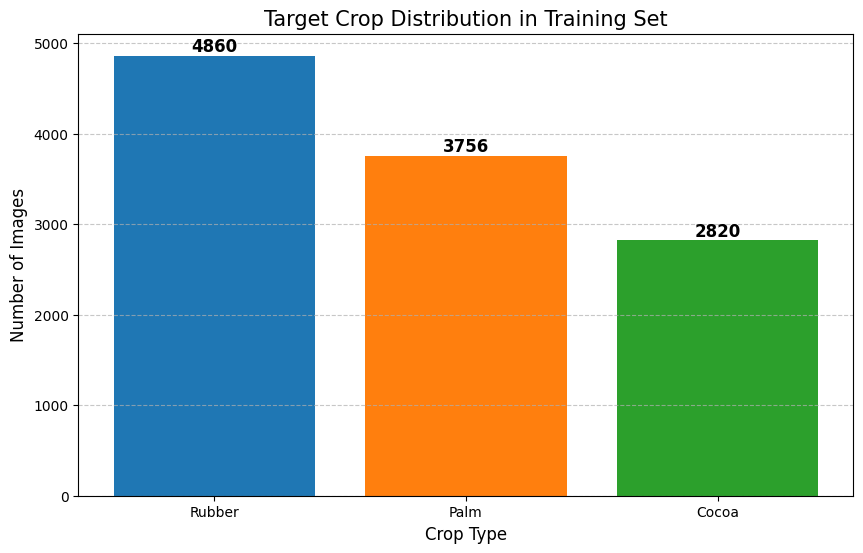

In [8]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Add counts above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Target Crop Distribution in Training Set', fontsize=15)
plt.xlabel('Crop Type', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Pipeline for Crop Classification

These functions are used for building a basic machine learning model and displaying the target distribution.

In [9]:
# --- Feature Engineering: Band Ratios ---

def compute_band_ratios(band_data: dict) -> dict:
    """
    Computes pairwise ratios between all available spectral bands.
    
    Ratios are effective features in remote sensing as they can cancel out 
    topographical effects and highlight spectral differences (similar to 
    how vegetation indices work).
    
    Args:
        band_data (dict): A dictionary where keys are band names (e.g., 'B02') 
                          and values are numpy arrays of the band's pixel data.
                          
    Returns:
        dict: A dictionary containing the computed ratio arrays. 
              Keys follow the format '{band1}_div_{band2}'.
    """
    ratio_features = {}
    
    # Iterate through every unique pair of bands
    for band1, band2 in itertools.combinations(band_data.keys(), 2):
        arr1 = band_data[band1]
        arr2 = band_data[band2]
        
        # Perform element-wise division. 
        # np.where handles division by zero by replacing the result with 0.0
        # We also add a tiny epsilon to the denominator for numerical stability if needed, 
        # but the np.where approach is usually sufficient for masks.
        ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
        
        # Generate a descriptive feature name
        ratio_name = f"{band1}_div_{band2}"
        ratio_features[ratio_name] = ratio
        
    return ratio_features

In [10]:
# --- Feature Engineering: Spectral Indices ---

def extract_ndvi(nir, red):
    """Normalized Difference Vegetation Index: General vegetation health."""
    return (nir - red) / (nir + red + EPSILON)

def extract_gndvi(nir, green):
    """Green NDVI: More sensitive to chlorophyll than standard NDVI."""
    return (nir - green) / (nir + green + EPSILON)

def extract_ndwi(nir, swir):
    """Normalized Difference Water Index: Detects moisture content in vegetation."""
    return (nir - swir) / (nir + swir + EPSILON)

# --- Soil Adjusted Indices ---
# Useful for younger plantations where ground/soil is visible between trees.

def extract_savi(nir, red, L=0.5):
    """Soil-Adjusted Vegetation Index: Corrects for soil brightness."""
    return ((nir - red) * (1 + L)) / (nir + red + L + EPSILON)

def extract_msavi(nir, red):
    """Modified Soil-Adjusted Vegetation Index: Minimizes soil background influence."""
    numerator = 2 * nir + 1
    denominator = np.sqrt((2 * nir + 1) ** 2 - 8 * (nir - red) + EPSILON)
    return (numerator - denominator) / 2

def extract_evi(nir, red, blue, G=2.5, C1=6, C2=7.5, L=1):
    """Enhanced Vegetation Index: Improves sensitivity in high biomass regions."""
    denominator = nir + C1 * red - C2 * blue + L
    return G * (nir - red) / (denominator + EPSILON)

# --- Red-Edge Indices ---
# Critical for classifying tree crops (Rubber/Palm) as Red Edge bands 
# penetrate deeper into the canopy and don't saturate as quickly as Red/NIR.

def extract_ndre(nir, red_edge):
    """Normalized Difference Red Edge: Estimates chlorophyll in dense canopies."""
    return (nir - red_edge) / (nir + red_edge + EPSILON)

def extract_reci(nir, red_edge):
    """Red-Edge Chlorophyll Index: Linearly correlated with chlorophyll content."""
    return (nir / (red_edge + EPSILON)) - 1

def extract_ndvi705(red_edge1, green):
    """NDVI705: Narrowband index for precision agriculture."""
    return (red_edge1 - green) / (red_edge1 + green + EPSILON)

def extract_red_edge_ndvi(red_edge, red):
    """Red Edge NDVI: A variant focusing on the red-edge transition."""
    return (red_edge - red) / (red_edge + red + EPSILON)

# --- Pigment Specific Indices ---

def extract_ari(green, red_edge):
    """Anthocyanin Reflectance Index: Sensitive to anthocyanin pigments."""
    return (1 / (green + EPSILON)) - (1 / (red_edge + EPSILON))

def extract_mcari(red_edge1, red, green):
    """Modified Chlorophyll Absorption in Reflectance Index."""
    diff = (red_edge1 - red) - 0.2 * (red_edge1 - green)
    return diff * (red_edge1 / (red + EPSILON))

In [11]:
# --- Data Loading Pipeline ---

def process_and_return_tiles(df: pd.DataFrame, is_train: bool = True, 
                             tile_size: int = TILE_SIZE, label_col: str = 'class'):
    """
    Reads satellite images from disk, pads them to a fixed size, and compiles them 
    into a NumPy array for model training/inference.
    
    Args:
        df (pd.DataFrame): Dataframe containing file paths.
        is_train (bool): If True, extracts labels. If False, ignores labels.
        tile_size (int): The target height/width to pad images to.
        label_col (str): The column name containing the target variable.
        
    Returns:
        tuple: (all_tiles_array, all_labels_array)
               - tiles shape: (N_samples, N_bands, tile_size, tile_size)
               - labels shape: (N_samples, 1) or None
    """
    all_tiles = []
    all_labels = []
    
    # Track skipped files for debugging
    skipped_count = 0

    print(f"🔄 Processing {len(df)} images...")
    
    for idx, row in df.iterrows():
        tile_path = row['tifPath']

        # Verify file exists before attempting read
        if tile_path and os.path.exists(tile_path):
            try:
                with rasterio.open(tile_path) as src:
                    # Read all bands. Shape: (bands, height, width)
                    raster = src.read()  

                # --- Padding Logic ---
                # Create a canvas of NaNs (or 0s) with the target fixed size
                bands, height, width = raster.shape
                
                # Check if image is larger than tile_size (cropping would be needed)
                if height > tile_size or width > tile_size:
                    # Optional: Add simple center crop logic here if needed
                    pass 
                
                # Initialize padded array with NaNs (handles variable image sizes)
                padded = np.full((bands, tile_size, tile_size), np.nan, dtype=np.float32)
                
                # Insert the actual image data into the top-left corner (or center)
                padded[:, :height, :width] = raster

                all_tiles.append(padded)

                if is_train:
                    # Retrieve the label (ensure column exists in df)
                    label = row[label_col] if label_col in df.columns else row.get('Target')
                    all_labels.append(label)

            except Exception as e:
                print(f"⚠️ Error reading {tile_path}: {e}")
                skipped_count += 1
                continue
        else:
            skipped_count += 1
            
    # Convert lists to NumPy arrays for ML processing
    # Shape: (N, Bands, H, W)
    all_tiles_array = np.stack(all_tiles)
    
    if is_train:
        # Shape: (N,)
        all_labels_array = np.array(all_labels)
    else:
        all_labels_array = None

    print(f"✅ Loaded {len(all_tiles)} tiles. (Skipped: {skipped_count})")
    print(f"   Output Shape: {all_tiles_array.shape}")
    
    return all_tiles_array, all_labels_array

In [12]:
# --- Feature Engineering: Statistical Aggregation ---

def stats(arr: np.ndarray) -> list:
    """
    Computes a comprehensive set of descriptive statistics for a given image band.
    
    This function flattens the 2D image array, removes NaN values (padding), 
    and calculates metrics to describe the distribution of pixel values.
    
    Args:
        arr (np.ndarray): Input 2D array (band or index).
        
    Returns:
        list: A list of 14 statistical features.
    """
    # Flatten and clean data (remove NaNs from padding)
    arr_flat = arr.flatten()
    arr_flat = arr_flat[~np.isnan(arr_flat)]

    # Handle empty arrays (e.g., if an image was fully masked/NaN)
    if arr_flat.size == 0:
        return [np.nan] * 14

    # Pre-calculate percentiles for efficiency
    q25 = np.percentile(arr_flat, 25)
    q75 = np.percentile(arr_flat, 75)
    iqr = q75 - q25
    std_dev = np.std(arr_flat)
    
    # Calculate statistics
    return [
        np.mean(arr_flat),                            # Mean
        np.median(arr_flat),                          # Median
        std_dev,                                      # Standard Deviation
        np.min(arr_flat),                             # Min
        np.max(arr_flat),                             # Max
        q25,                                          # 25th Percentile
        q75,                                          # 75th Percentile
        iqr,                                          # Interquartile Range
        np.mean(arr_flat) / (std_dev + 1e-8),         # Signal-to-Noise Ratio (Mean/Std)
        skew(arr_flat),                               # Skewness (Asymmetry)
        kurtosis(arr_flat),                           # Kurtosis (Tail heaviness)
        np.count_nonzero(arr_flat) / len(arr_flat),   # Non-zero ratio (Sparsity check)
        np.sum(arr_flat < q25) / len(arr_flat),       # Ratio of pixels in lower tail
        np.sum(arr_flat > q75) / len(arr_flat),       # Ratio of pixels in upper tail
    ]

In [13]:
# --- Feature Extraction Pipeline ---

def extract_features_from_tiles(tiles: np.ndarray) -> pd.DataFrame:
    """
    Orchestrates the extraction of features from raw image tiles.
    
    Process:
    1. Unpack Sentinel-2 bands.
    2. Calculate Spectral Indices.
    3. Calculate Ratios between all bands and indices.
    4. Compute 14 statistical metrics for every single band, index, and ratio.
    
    Args:
        tiles (np.ndarray): Input array of shape (N, 12, H, W).
    
    Returns:
        pd.DataFrame: Tabular dataset where rows are observations and columns are features.
    """
    features_list = []
    
    # Define column suffixes based on the 'stats' function outputs
    stat_names = [
        'mean', 'median', 'std', 'min', 'max', 'q25', 'q75', 'iqr', 'cv',
        'skew', 'kurt', 'nonzero_prop', 'low_prop', 'high_prop'
    ]

    print(f"⚙️ Extracting features from {len(tiles)} tiles...")
    
    for i, tile in enumerate(tiles):
        # --- 1. Band Unpacking (Sentinel-2 Mapping) ---
        # 0:B1, 1:B2, 2:B3, 3:B4, 4:B5, 5:B6, 6:B7, 7:B8, 8:B8A, 9:B9, 10:B11, 11:B12
        coast_aeros = tile[0]
        blue        = tile[1]
        green       = tile[2]
        red         = tile[3]
        red_edge1   = tile[4]
        red_edge2   = tile[5]
        red_edge3   = tile[6]
        nir         = tile[7]
        red_edge4   = tile[8]  # B8A (Narrow NIR)
        water_vapor = tile[9]
        b11         = tile[10] # SWIR 1
        b12         = tile[11] # SWIR 2

        # --- 2. Spectral Index Calculation ---
        # We calculate these first so we can also compute ratios involving them
        idx_dict = {
            "ndvi": extract_ndvi(nir, red),
            "savi": extract_savi(nir, red),
            "evi": extract_evi(nir, red, blue),
            "ndre": extract_ndre(nir, red_edge1),
            "gndvi": extract_gndvi(nir, green),
            "reci": extract_reci(nir, red_edge3),
            "ndwi": extract_ndwi(nir, b11),
            "ndvi705": extract_ndvi705(red_edge1, green),
            "red_edge_ndvi": extract_red_edge_ndvi(red_edge3, red),
            "ari": extract_ari(green, red_edge1),
            "mcari": extract_mcari(red_edge1, red, green),
            "msavi": extract_msavi(nir, red)
        }

        # Combine Raw Bands and Indices into one dictionary for uniform processing
        # Note: 'coast_aeros' is often noisy, sometimes excluded, but included here for completeness
        full_band_dict = {
            "B1_aerosol": coast_aeros, "B2_Blue": blue, "B3_Green": green, "B4_Red": red,
            "B5_Red_E1": red_edge1, "B6_Red_E2": red_edge2, "B7_Red_E3": red_edge3,
            "B8_NIR": nir, "B8A_Red_E4": red_edge4, "B9_Water": water_vapor, 
            "B11_SWIR1": b11, "B12_SWIR2": b12,
            **idx_dict # Unpack indices
        }
        
        # --- 3. Ratio Calculation ---
        # This computes ratios between ALL bands and ALL indices (Combinatorial explosion!)
        ratio_features = compute_band_ratios(full_band_dict)

        # --- 4. Statistical Aggregation ---
        current_features = []
        
        # A. Stats for Base Bands & Indices
        for band_name, band_data in full_band_dict.items():
            current_features.extend(stats(band_data))
            
        # B. Stats for Ratios
        for ratio_name, ratio_data in ratio_features.items():
            current_features.extend(stats(ratio_data))
        
        features_list.append(current_features)

        # Optional progress print for large datasets
        if (i + 1) % 500 == 0:
            print(f"   Processed {i + 1}/{len(tiles)}")

    # --- Column Naming ---
    # We must replicate the order used in the loop above to name columns correctly
    
    # Base keys (Bands + Indices)
    base_keys = list(full_band_dict.keys())
    
    # Ratio keys (generated by itertools in the helper function)
    # We create a dummy call to get the keys in the exact same order
    dummy_ratios = compute_band_ratios({k: np.zeros(1) for k in base_keys})
    ratio_keys = list(dummy_ratios.keys())
    
    all_channel_names = base_keys + ratio_keys
    
    # Generate final column names: {Channel}_{Stat}
    # e.g., "NDVI_mean", "B2_Blue_div_B4_Red_skew"
    final_columns = [f"{channel}_{stat}" for channel in all_channel_names for stat in stat_names]

    return pd.DataFrame(features_list, columns=final_columns)

In [14]:
# --- Main Execution Pipeline: Training Data ---

# Define the target months based on Test Set availability
# We filter the training data to match the temporal distribution of the test set.
# This prevents the model from learning seasonal patterns (e.g., specific rain/drought effects)
# that don't exist in the inference period.
TARGET_MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec']

train_dfs = []

print(f"🗓️ Starting processing for months: {TARGET_MONTHS}")

for mth in TARGET_MONTHS:
    print(f"\n--- Processing Month: {mth} ---")
    
    # 1. Filter Dataframe for specific month
    monthly_df = train[train['month'] == mth]
    
    # 2. Load Image Tiles (returns X array and y labels)
    tile_array, labels = process_and_return_tiles(monthly_df, is_train=True)
    
    # 3. Extract Features (Heavy computation)
    if len(tile_array) > 0:
        temp_X = extract_features_from_tiles(tile_array)
        
        # 4. Re-attach Metadata
        temp_X['month'] = mth
        temp_X['Target'] = labels # Store labels directly in the feature set for now
        
        train_dfs.append(temp_X)
        
        # Optional: Free up memory
        del tile_array
        gc.collect()
    else:
        print(f"⚠️ No data found for month {mth}")

🗓️ Starting processing for months: ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec']

--- Processing Month: Jan ---
🔄 Processing 953 images...
✅ Loaded 953 tiles. (Skipped: 0)
   Output Shape: (953, 12, 326, 326)
⚙️ Extracting features from 953 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



--- Processing Month: Feb ---
🔄 Processing 953 images...
✅ Loaded 953 tiles. (Skipped: 0)
   Output Shape: (953, 12, 326, 326)
⚙️ Extracting features from 953 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


   Processed 500/953

--- Processing Month: Mar ---
🔄 Processing 953 images...
✅ Loaded 953 tiles. (Skipped: 0)
   Output Shape: (953, 12, 326, 326)
⚙️ Extracting features from 953 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


   Processed 500/953

--- Processing Month: Apr ---
🔄 Processing 953 images...
✅ Loaded 953 tiles. (Skipped: 0)
   Output Shape: (953, 12, 326, 326)
⚙️ Extracting features from 953 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


   Processed 500/953

--- Processing Month: Nov ---
🔄 Processing 953 images...
✅ Loaded 953 tiles. (Skipped: 0)
   Output Shape: (953, 12, 326, 326)
⚙️ Extracting features from 953 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


   Processed 500/953

--- Processing Month: Dec ---
🔄 Processing 953 images...
✅ Loaded 953 tiles. (Skipped: 0)
   Output Shape: (953, 12, 326, 326)
⚙️ Extracting features from 953 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


   Processed 500/953


In [15]:
# --- Data Aggregation & ID Alignment ---

# Calculate the expected number of rows per month.
# The assumption is that the original 'train' dataset contains 12 entries 
# (one per month) for every unique field location.
desired_rows = int(train.shape[0] / 12)

print(f"📏 Expected rows per month: {desired_rows}")

filtered_dfs = []

# Get the reference IDs from the January data to ensure consistency across all months
# We reset index to ensure 0..N alignment matches the feature dataframes
ref_ids = train[train['month'] == 'Jan']['ID'].str.split('_', expand=True)[1].reset_index(drop=True)

for mth, df in zip(['Jan','Feb','Mar','Apr', 'Nov','Dec'], train_dfs):
    # Data Consistency Check:
    # Only include months that have the complete set of processed images (matches desired_rows).
    # This filters out months where image processing might have failed for some tiles.
    if df.shape[0] == desired_rows:
        print(f"   ✅ Keeping month {mth} (Rows: {len(df)})")
        
        # Reset index of the feature dataframe to match the reference IDs Series
        df = df.reset_index(drop=True)
        
        # Assign the field ID (reconstructed from the Jan baseline)
        # This ensures that row N in 'Nov' gets the same ID as row N in 'Jan'
        df['ID'] = 'ID_' + ref_ids
        
        filtered_dfs.append(df)
    else:
        print(f"   ⚠️ Dropping month {mth} - Row count mismatch (Found: {len(df)}, Expected: {desired_rows})")

# Concatenate all valid monthly datasets
comb_train = pd.concat(filtered_dfs, axis=0).reset_index(drop=True)

print(f"\n✅ Final Training Set Assembled.")
print(f"   Shape: {comb_train.shape}")
display(comb_train.head())

📏 Expected rows per month: 953
   ✅ Keeping month Jan (Rows: 953)
   ✅ Keeping month Feb (Rows: 953)
   ✅ Keeping month Mar (Rows: 953)
   ✅ Keeping month Apr (Rows: 953)
   ✅ Keeping month Nov (Rows: 953)
   ✅ Keeping month Dec (Rows: 953)

✅ Final Training Set Assembled.
   Shape: (5718, 4203)


,B1_aerosol_mean,B1_aerosol_median,B1_aerosol_std,B1_aerosol_min,B1_aerosol_max,B1_aerosol_q25,B1_aerosol_q75,B1_aerosol_iqr,B1_aerosol_cv,B1_aerosol_skew,...,mcari_div_msavi_iqr,mcari_div_msavi_cv,mcari_div_msavi_skew,mcari_div_msavi_kurt,mcari_div_msavi_nonzero_prop,mcari_div_msavi_low_prop,mcari_div_msavi_high_prop,month,Target,ID
0,2573.092285,2573.0,8.352156,2555.0,2605.0,2567.0,2579.0,12.0,308.075226,0.412736,...,86.478912,7.984561,0.333512,-0.005448,1.0,0.249904,0.249904,Jan,3,ID_h14T0B
1,2536.794678,2535.0,12.369866,2515.0,2574.0,2527.0,2545.0,18.0,205.078583,0.632793,...,149.264465,6.392583,0.231796,-0.381053,1.0,0.249904,0.249904,Jan,3,ID_KbyKOr
2,2530.286621,2529.0,10.403985,2501.0,2600.0,2523.0,2537.0,14.0,243.203598,0.944190,...,108.337280,7.794470,-0.159045,0.998143,1.0,0.250000,0.250000,Jan,3,ID_t4Tmmn
3,2559.110840,2555.0,28.098471,2530.0,2823.0,2545.0,2566.0,21.0,91.076515,6.099442,...,109.529846,8.399770,-0.115401,0.267247,1.0,0.249904,0.249904,Jan,3,ID_yipWoC
4,2682.882324,2577.0,279.120483,2526.0,3972.0,2541.0,2652.0,111.0,9.611915,2.772251,...,180.276947,2.662519,-0.718905,6.712333,1.0,0.249519,0.249904,Jan,3,ID_XKiksa


In [26]:
# ---Feature Splitting ---

# Verify Class Distribution after aggregation
print("📊 Final Class Distribution in Training Set:")
print(comb_train['Target'].value_counts())
# Expected Output:
# 3 (Rubber): 2430
# 2 (Palm):   1878
# 1 (Cocoa):  1410

# Create a copy to preserve the original dataframe
final_df = comb_train.copy()

# --- Define Features (X) and Target (y) ---

# Drop metadata columns that shouldn't be used for prediction
# We drop 'class' from X because it's the target.
# We drop 'Target' (string) and 'ID' (unique identifier).
X = final_df.drop(columns=['ID', 'Target', 'class'])
y = final_df['Target']

# --- Stratification Helper ---
# Create a composite column for Stratified K-Fold.
# This ensures that when we split the data, we preserve the distribution 
# of BOTH the crop type and the month across folds.
final_df['strat'] = final_df['Target'].astype('str') + '_' + final_df['month'].astype('str')

# --- Categorical Feature Encoding ---
# Convert 'month' from string ('Jan') to integer (1)
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'Nov': 11, 'Dec': 12}
X['month'] = X['month'].map(month_map)

# Explicitly define categorical columns for CatBoost
cat_cols = ['month']

print(f"✅ Feature Matrix X shape: {X.shape}")
print(f"✅ Target Vector y shape: {y.shape}")
print(f"📝 Categorical Columns: {cat_cols}")

📊 Final Class Distribution in Training Set:
Target
3    2430
2    1878
1    1410
Name: count, dtype: int64
✅ Feature Matrix X shape: (5718, 4201)
✅ Target Vector y shape: (5718,)
📝 Categorical Columns: ['month']


In [17]:
# --- Hyperparameter Configuration ---

# These parameters were tuned using Optuna to maximize the F1-Score.
# Optimization Result: Improved F1 from 0.8864 (Baseline) -> 0.8978 (Tuned)

best_params = {
    # Core Boosting Parameters
    'iterations': 493,                 # Total number of trees to build
    'learning_rate': 0.118698,         # Step size shrinkage to prevent overfitting
    'depth': 8,                        # Depth of trees (High depth = captures complex interactions)
    
    # Regularization & Generalization
    'l2_leaf_reg': 0.206077,           # L2 regularization on leaf weights (controls smoothness)
    'min_data_in_leaf': 32,            # Minimum samples per leaf (prevents noisy splits)
    'random_strength': 0.000966,       # Randomness added to scoring splits (helps with variance)
    
    # Sampling Strategy
    'colsample_bylevel': 0.922582,     # % of features used for each split (feature subsampling)
    'bootstrap_type': 'No',            # No bootstrapping (uses all data, reduces bias)
    
    # Fixed Settings for Multi-class Classification
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1',
    'random_seed': 42,
    'task_type': 'CPU',                # Change to 'GPU' if available
    'allow_writing_files': False       # Suppress internal file generation
}

print("✅ Optimal hyperparameters loaded.")
display(best_params)

✅ Optimal hyperparameters loaded.


{'iterations': 493,
 'learning_rate': 0.118698,
 'depth': 8,
 'l2_leaf_reg': 0.206077,
 'min_data_in_leaf': 32,
 'random_strength': 0.000966,
 'colsample_bylevel': 0.922582,
 'bootstrap_type': 'No',
 'loss_function': 'MultiClass',
 'eval_metric': 'TotalF1',
 'random_seed': 42,
 'task_type': 'CPU',
 'allow_writing_files': False}

In [18]:
# --- Feature Selection ---

# These 128 features were selected via Recursive Feature Elimination (RFE)
# using the eli5 library. The selection was based on Permutation Importance.
# Baseline Performance with this set: F1-Score ~ 0.8864

selected_features = [
    # --- Single Band/Index Stats ---
    'B1_aerosol_min', 'B1_aerosol_q25', 'B9_Water_max', 
    'reci_median', 'reci_q25', 'reci_q75', 'reci_iqr', 
    'ndwi_high_prop', 'red_edge_ndvi_max', 'ari_median', 'ari_q25', 'mcari_skew', 
    
    # --- Aerosol Ratios ---
    'B1_aerosol_div_B2_Blue_median', 'B1_aerosol_div_B2_Blue_q75', 
    'B1_aerosol_div_B3_Green_median', 'B1_aerosol_div_B3_Green_q75', 
    'B1_aerosol_div_B8A_Red_E4_iqr', 'B1_aerosol_div_B9_Water_min', 
    'B1_aerosol_div_B9_Water_q25', 'B1_aerosol_div_B12_SWIR2_max', 
    'B1_aerosol_div_reci_median', 'B1_aerosol_div_reci_iqr', 
    'B1_aerosol_div_ndwi_q25', 
    
    # --- Visible Band Ratios ---
    'B2_Blue_div_B3_Green_q75', 'B2_Blue_div_B3_Green_iqr', 'B2_Blue_div_B4_Red_max', 
    'B2_Blue_div_B9_Water_min', 'B2_Blue_div_B9_Water_q25', 'B2_Blue_div_B11_SWIR1_iqr', 
    'B2_Blue_div_ndwi_min', 'B2_Blue_div_ndwi_q25', 'B3_Green_div_B4_Red_max', 
    'B3_Green_div_B9_Water_min', 'B4_Red_div_B9_Water_min', 'B4_Red_div_B12_SWIR2_median', 
    'B4_Red_div_B12_SWIR2_iqr', 'B4_Red_div_reci_q75', 
    
    # --- Red Edge Ratios (High Importance) ---
    'B5_Red_E1_div_B6_Red_E2_high_prop', 'B5_Red_E1_div_B11_SWIR1_median', 
    'B5_Red_E1_div_B11_SWIR1_q25', 'B5_Red_E1_div_B12_SWIR2_mean', 'B5_Red_E1_div_B12_SWIR2_median', 
    'B5_Red_E1_div_B12_SWIR2_max', 'B5_Red_E1_div_B12_SWIR2_q25', 'B5_Red_E1_div_B12_SWIR2_q75', 
    'B6_Red_E2_div_B7_Red_E3_q25', 'B6_Red_E2_div_B8_NIR_skew', 
    'B6_Red_E2_div_B11_SWIR1_max', 'B6_Red_E2_div_B11_SWIR1_q75', 'B6_Red_E2_div_B12_SWIR2_max', 
    'B7_Red_E3_div_B8_NIR_median', 'B7_Red_E3_div_B8_NIR_q75', 
    'B7_Red_E3_div_B8A_Red_E4_median', 'B7_Red_E3_div_B8A_Red_E4_max', 
    'B7_Red_E3_div_B8A_Red_E4_q25', 'B7_Red_E3_div_B8A_Red_E4_iqr', 
    'B7_Red_E3_div_B9_Water_median', 'B7_Red_E3_div_B9_Water_max', 
    'B7_Red_E3_div_B11_SWIR1_max', 'B7_Red_E3_div_B11_SWIR1_q75', 'B7_Red_E3_div_B12_SWIR2_max', 
    'B7_Red_E3_div_mcari_kurt', 'B8A_Red_E4_div_B9_Water_max', 
    'B8A_Red_E4_div_B11_SWIR1_max', 'B8A_Red_E4_div_B11_SWIR1_q75', 
    
    # --- NIR & SWIR Ratios ---
    'B8_NIR_div_B9_Water_max', 'B8_NIR_div_ndwi_max', 'B8_NIR_div_red_edge_ndvi_q25', 
    'B8_NIR_div_msavi_kurt', 'B9_Water_div_B12_SWIR2_max', 'B9_Water_div_reci_median', 
    'B9_Water_div_reci_min', 'B9_Water_div_reci_q25', 
    'B9_Water_div_reci_iqr', 'B9_Water_div_msavi_q25', 'B11_SWIR1_div_B12_SWIR2_max', 
    'B11_SWIR1_div_B12_SWIR2_q25', 'B11_SWIR1_div_reci_max', 'B12_SWIR2_div_ndwi_cv', 
    
    # --- Vegetation Index Ratios ---
    'ndvi_div_ndre_median', 'ndvi_div_ndre_q75', 'ndvi_div_ndwi_median', 
    'savi_div_evi_kurt', 'savi_div_ndre_mean', 'savi_div_ndre_median', 
    'savi_div_ndre_q75', 'savi_div_ari_std', 'savi_div_msavi_max', 
    'evi_div_gndvi_q25', 'evi_div_reci_max', 'evi_div_reci_q75', 
    'evi_div_reci_iqr', 'evi_div_red_edge_ndvi_q25', 'evi_div_ari_median', 
    'evi_div_ari_cv', 'evi_div_mcari_median', 'evi_div_mcari_q25', 
    'evi_div_mcari_q75', 'evi_div_mcari_kurt', 'ndre_div_red_edge_ndvi_median', 
    'ndre_div_red_edge_ndvi_q75', 'ndre_div_msavi_median', 'ndre_div_msavi_q25', 
    'ndre_div_msavi_q75', 'ndre_div_msavi_iqr', 'gndvi_div_ndvi705_cv', 
    'gndvi_div_red_edge_ndvi_q25', 'gndvi_div_mcari_median', 
    'gndvi_div_mcari_q25', 'gndvi_div_mcari_q75', 
    
    # --- RECI Interaction Ratios ---
    'reci_div_ndwi_median', 'reci_div_ndwi_q25', 'reci_div_ndvi705_std', 
    'reci_div_ndvi705_max', 'reci_div_ndvi705_q25', 'reci_div_ndvi705_iqr', 
    'reci_div_ndvi705_kurt', 'reci_div_ari_std', 'reci_div_ari_q75', 
    'reci_div_mcari_max', 'reci_div_msavi_kurt', 
    
    # --- Complex Index Interactions ---
    'ndwi_div_red_edge_ndvi_min', 'ndwi_div_mcari_min', 'ndvi705_div_mcari_q25', 
    'red_edge_ndvi_div_mcari_q75', 'red_edge_ndvi_div_msavi_q75', 
    'ari_div_msavi_high_prop', 'mcari_div_msavi_q75'
]

# Update the feature matrix X to include only selected features
X = X[selected_features]
print(f"✅ Feature selection applied. X shape: {X.shape}")

✅ Feature selection applied. X shape: (5718, 128)


In [27]:
# --- Cross-Validation & Model Training ---

# Initialize Stratified Group K-Fold
# - n_splits=5: Standard 5-fold cross-validation.
# - Stratification: Ensures balanced classes/months across folds (using 'strat').
# - Grouping: Ensures ALL months for a specific Field ID end up in the SAME fold. 
#   (Prevents data leakage where the model memorizes a specific field).
cv = StratifiedGroupKFold(n_splits=5)

fit_models = []
test_scores = []
train_scores = []

# Define features to use (from previous selection step)
selected_X = X[selected_features].copy()

print("🚀 Starting 5-Fold Cross-Validation...")

for fold, (train_idx, test_idx) in enumerate(cv.split(selected_X, final_df['strat'], groups=final_df['ID'])):
    
    # Split data
    X_train, X_test = selected_X.iloc[train_idx], selected_X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Handle Categorical Features (Ensure Integer Type for CatBoost)
    # We identify the index of categorical columns for the Pool constructor
    cat_feat_indices = [i for i, col in enumerate(X_train.columns) if col in cat_cols]
    
    for col in cat_cols:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype(int)
            X_test[col] = X_test[col].astype(int)

    # Create CatBoost Pools (Optimized internal data structure)
    train_pool = Pool(X_train, y_train, cat_features=cat_feat_indices)
    test_pool = Pool(X_test, y_test, cat_features=cat_feat_indices)
    
    # Initialize Model with Optimized Hyperparameters
    model = CatBoostClassifier(
        **best_params,
        use_best_model=True,
        silent=True, # Suppress iteration logs
    )
    
    # Train
    model.fit(
        train_pool,
        eval_set=test_pool,
        early_stopping_rounds=50, # Stop if validation score doesn't improve
        verbose=False
    )
    
    # Evaluation
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Calculate Weighted F1 Score
    score_test = f1_score(y_test, y_pred_test, average='weighted')
    score_train = f1_score(y_train, y_pred_train, average='weighted')
    
    # Store results
    fit_models.append(model)
    test_scores.append(score_test)
    train_scores.append(score_train)
    
    print(f"   📂 Fold {fold+1} | Test F1: {score_test:.5f} | Train F1: {score_train:.5f}")

# --- Final Results ---
print("\n🏆 Cross-Validation Complete.")
print(f"   Mean Training F1: {np.mean(train_scores):.5f}")
print(f"   Mean Validation F1: {np.mean(test_scores):.5f}")

# Expected Output:
# Mean Validation F1: ~0.89147

🚀 Starting 5-Fold Cross-Validation...
   📂 Fold 1 | Test F1: 0.92554 | Train F1: 1.00000
   📂 Fold 2 | Test F1: 0.86698 | Train F1: 1.00000
   📂 Fold 3 | Test F1: 0.89135 | Train F1: 0.99978
   📂 Fold 4 | Test F1: 0.86150 | Train F1: 0.99956
   📂 Fold 5 | Test F1: 0.91197 | Train F1: 1.00000

🏆 Cross-Validation Complete.
   Mean Training F1: 0.99987
   Mean Validation F1: 0.89147


In [28]:
# --- Inference Pipeline: Test Data Processing ---

# We must process the test data using the EXACT same months as the training set
# to maintain feature consistency.
TARGET_MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec']

test_dfs = []

print(f"🚀 Starting Inference Processing for months: {TARGET_MONTHS}")

for mth in TARGET_MONTHS:
    print(f"\n--- Processing Test Month: {mth} ---")
    
    # 1. Filter Test DataFrame for specific month
    monthly_test_df = test[test['month'] == mth]
    
    if monthly_test_df.empty:
        print(f"⚠️ No test data found for {mth}")
        continue

    # 2. Load Image Tiles (is_train=False, so no labels are returned)
    # The '_' variable ignores the second return value (which would be labels)
    tile_array, _ = process_and_return_tiles(monthly_test_df, is_train=False)
    
    # 3. Extract Features
    if len(tile_array) > 0:
        temp_X = extract_features_from_tiles(tile_array)
        
        # 4. Re-attach Metadata
        temp_X['month'] = mth
        
        test_dfs.append(temp_X)
        
        # Memory cleanup
        del tile_array
        gc.collect()
    else:
        print(f"⚠️ Failed to load tiles for {mth}")

# Combine into a single Test DataFrame (if you want to inspect it)
# Note: Actual alignment happens in the next step
print(f"\n✅ Processed {len(test_dfs)} monthly batches.")

🚀 Starting Inference Processing for months: ['Jan', 'Feb', 'Mar', 'Apr', 'Nov', 'Dec']

--- Processing Test Month: Jan ---
🔄 Processing 282 images...
✅ Loaded 282 tiles. (Skipped: 0)
   Output Shape: (282, 12, 326, 326)
⚙️ Extracting features from 282 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



--- Processing Test Month: Feb ---
🔄 Processing 282 images...
✅ Loaded 282 tiles. (Skipped: 0)
   Output Shape: (282, 12, 326, 326)
⚙️ Extracting features from 282 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



--- Processing Test Month: Mar ---
🔄 Processing 282 images...
✅ Loaded 282 tiles. (Skipped: 0)
   Output Shape: (282, 12, 326, 326)
⚙️ Extracting features from 282 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



--- Processing Test Month: Apr ---
🔄 Processing 282 images...
✅ Loaded 282 tiles. (Skipped: 0)
   Output Shape: (282, 12, 326, 326)
⚙️ Extracting features from 282 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



--- Processing Test Month: Nov ---
🔄 Processing 282 images...
✅ Loaded 282 tiles. (Skipped: 0)
   Output Shape: (282, 12, 326, 326)
⚙️ Extracting features from 282 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



--- Processing Test Month: Dec ---
🔄 Processing 282 images...
✅ Loaded 282 tiles. (Skipped: 0)
   Output Shape: (282, 12, 326, 326)
⚙️ Extracting features from 282 tiles...


/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/tmp/ipykernel_55/2432886969.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(arr2 != 0, arr1 / arr2, 0.0)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1202: RuntimeWarning: overflow encountered in square
  s = s**2
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:1204: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)



✅ Processed 6 monthly batches.


In [29]:
# --- Test Data Alignment & ID Reconstruction ---

# Calculate expected rows per month for the test set
# (Total Test Rows / 12 Months)
desired_rows = int(test.shape[0] / 12)
print(f"📏 Expected test rows per month: {desired_rows}")

filtered_test_dfs = []

# Extract reference IDs from the January test data.
# This serves as the 'Master ID List' to ensure that Row N in every monthly dataframe 
# corresponds to the exact same Field ID.
ref_test_ids = test[test['month'] == 'Jan']['ID'].str.split('_', expand=True)[1].reset_index(drop=True)

for df in test_dfs:
    # Consistency Check: Only keep months where all images were successfully processed
    if df.shape[0] == desired_rows:
        
        # Reset index to align with the reference ID list
        df = df.reset_index(drop=True)
        
        # Reconstruct the ID column using the January baseline
        df['ID'] = 'ID_' + ref_test_ids
        
        filtered_test_dfs.append(df)
    else:
        print(f"⚠️ Skipping a month due to row mismatch (Got {df.shape[0]}, Expected {desired_rows})")

# Combine aligned monthly test sets into one master dataframe
comb_test = pd.concat(filtered_test_dfs, axis=0).reset_index(drop=True)

print(f"✅ Final Test Set Assembled.")
print(f"   Shape: {comb_test.shape}")

📏 Expected test rows per month: 282
✅ Final Test Set Assembled.
   Shape: (1692, 4202)


In [30]:
# --- Test Data Preprocessing ---

# Create a clean copy for transformation
test_cond = comb_test.copy()

# 1. Encode Temporal Features
# We apply the EXACT same mapping used in training to ensure the model interprets 'Jan' as 1, etc.
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'Nov': 11, 'Dec': 12}
test_cond['month'] = test_cond['month'].map(month_map)

# 2. Enforce Data Types for Categorical Features
# CatBoost is strict about types. If we trained on integers, we must predict on integers.
print(f"⚙️ Formatting categorical columns: {cat_cols}")

for col in cat_cols:
    if col in test_cond.columns:
        test_cond[col] = test_cond[col].astype('int')

# Verify the feature set matches the training features
# We select only the 128 features identified by RFE (plus the 'month' categorical)
X_test_final = test_cond[selected_features + cat_cols]

print(f"✅ Final Test Feature Matrix Ready.")
print(f"   Shape: {X_test_final.shape}")

⚙️ Formatting categorical columns: ['month']
✅ Final Test Feature Matrix Ready.
   Shape: (1692, 129)


In [34]:
# --- Ensemble Prediction (Hard Voting Prep) ---

predictions_dict = {}

print(f"🔮 Generating predictions using {len(fit_models)} trained models...")

# Iterate through each of the 5 trained models (one from each fold)
for i, model in enumerate(fit_models):
    
    # Select the exact same features used during training (RFE 128 features)
    # Ensure 'cat_cols' are handled if they were part of training (CatBoost handles this internally 
    # if passed to the pool or if dataframe types are correct)
    X_test_subset = test_cond[selected_features] 
    
    # Generate Class Predictions (Returns [1, 2, 3...])
    # Note: If you wanted probabilities for Soft Voting, use model.predict_proba()
    y_pred_class = model.predict(X_test_subset)
    
    # Store result flattened (1D array)
    predictions_dict[f'fold_{i+1}'] = y_pred_class.ravel()

# Convert to DataFrame where every column is a fold's vote
pred_df = pd.DataFrame(predictions_dict)

print("✅ Predictions collected.")
display(pred_df.head())

🔮 Generating predictions using 5 trained models...
✅ Predictions collected.


,fold_1,fold_2,fold_3,fold_4,fold_5
0,2,2,2,2,2
1,2,2,2,2,2
2,3,3,3,3,3
3,3,3,3,3,3
4,3,3,3,3,3


In [36]:
# --- Aggregation Preparation: Month-Fold Organization ---

# 1. Attach the 5-fold predictions to the metadata
# test_pred now contains the ID, Month, and the 5 prediction columns (0, 1, 2, 3, 4)
test_pred = pd.concat([test_cond, pred_df], axis=1)

pred_ind_dfs = []

print(f"📦 Restructuring predictions by month...")

# Iterate through the mapped month integers (1, 2, 3, 4, 11, 12)
for mth in month_map.values():
    
    # Select predictions corresponding to the current month
    # We keep 'ID' for alignment and the columns 0-4 (the fold predictions)
    temp_tp_df = test_pred[test_pred['month'] == mth][['ID', 'month', 'fold_1',
                                                       'fold_2', 'fold_3',
                                                       'fold_4', 'fold_5']].copy()
    
    # Rename columns to ensure uniqueness when we merge later
    # Format: "{Month}_{FoldIndex}" (e.g., '1_0' is Jan, Fold 0)
    new_columns = {
        'fold_1': f'{mth}_0',
        'fold_2': f'{mth}_1',
        'fold_3': f'{mth}_2',
        'fold_4': f'{mth}_3',
        'fold_5': f'{mth}_4'
    }
    temp_tp_df = temp_tp_df.rename(columns=new_columns)
    
    # Sort by ID to ensure strict row-alignment across all monthly dataframes
    temp_tp_df = temp_tp_df.sort_values('ID').reset_index(drop=True)
    
    pred_ind_dfs.append(temp_tp_df)

print(f"✅ Generated {len(pred_ind_dfs)} monthly prediction frames.")
# Each frame represents the voting block for one specific month.

📦 Restructuring predictions by month...
✅ Generated 6 monthly prediction frames.


In [37]:
# --- Final Submission Generation: The Grand Vote ---

# Concatenate all monthly prediction frames side-by-side
# Resulting Shape: (N_Fields, Total_Columns)
# where columns include metadata + 30 prediction columns (5 folds * 6 months)
pred_ind = pd.concat(pred_ind_dfs, axis=1)

# Initialize Submission DataFrame
sub = pd.DataFrame()

# 1. Calculate the Mode (Majority Vote) across all prediction columns
# We filter for columns containing '_' (e.g., '1_0', '11_4') which hold the votes.
# This aggregates 30 distinct opinions for every single field.
print("🗳️ Calculating consensus (Mode) across 30 votes per field...")
voting_cols = [col for col in pred_ind.columns if '_' in col]
sub['class'] = pred_ind[voting_cols].mode(axis=1)[0]

# 2. Extract Field IDs
# We take the ID from the first column of the concatenated frame (all are aligned)
sub['ID'] = pred_ind.iloc[:, 0]

# 3. Decode Labels (Integer -> String)
# Map predictions back to the required competition format
inverse_class_map = {3: 'Rubber', 1: 'Cocoa', 2: 'Palm'}
sub['Target'] = sub['class'].map(inverse_class_map)

# 4. Final Formatting
# Remove the integer class column, keeping only ID and Target
sub = sub.drop(columns=['class'])

# --- Final Sanity Check ---
print("\n📊 Predicted Class Distribution in Test Set:")
print(sub['Target'].value_counts())
# Output:
# Rubber    119
# Palm      109
# Cocoa      54

# Save to CSV
sub.to_csv(SUBMISSION_PATH, index=False)
print(f"\n✅ Submission file saved to: {SUBMISSION_PATH}")

🗳️ Calculating consensus (Mode) across 30 votes per field...

📊 Predicted Class Distribution in Test Set:
Target
Rubber    119
Palm      109
Cocoa      54
Name: count, dtype: int64

✅ Submission file saved to: submission.csv
